## Homework

The goal of this homework is to create a simple training pipeline, use mlflow to track experiments and register best model, but use Mage for it.

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), the **Yellow** taxi data for March, 2023. 

In [73]:
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression



## Question 1. Select the Tool

You can use the same tool you used when completing the module,
or choose a different one for your homework.

What's the name of the orchestrator you chose? 

##### **A:** Apache Airflow

## Question 2. Version

What's the version of the orchestrator? 

##### **A:** 3.0.1

In [2]:
! airflow version

3.0.1


## Question 3. Creating a pipeline

Let's read the March 2023 Yellow taxi trips data.

https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

How many records did we load? 

- ~~3,003,766~~
- ~~3,203,766~~
- **3,403,766**
- ~~3,603,766~~

(Include a print statement in your code)

In [3]:
! ls -al ../data/

total 152612
drwxrwxrwx+  3 codespace codespace     4096 Jun  6 20:11 .
drwxrwxrwx+ 10 codespace root          4096 Jun  6 20:03 ..
-rw-rw-rw-   1 codespace codespace  1427002 Jun  6 20:03 green_tripdata_2023-01.parquet
-rw-rw-rw-   1 codespace codespace  1533740 Jun  6 20:03 green_tripdata_2023-02.parquet
-rw-rw-rw-   1 codespace codespace  1730999 Jun  6 20:03 green_tripdata_2023-03.parquet
drwxrwxrwx+  2 codespace codespace     4096 Jun  6 20:03 output
-rw-rw-rw-   1 codespace codespace 47673370 Jun  6 20:06 yellow_tripdata_2023-01.parquet
-rw-rw-rw-   1 codespace codespace 47748012 Jun  6 20:06 yellow_tripdata_2023-02.parquet
-rw-rw-rw-   1 codespace codespace 56127762 Jun  6 20:11 yellow_tripdata_2023-03.parquet


In [4]:
fname = '../data/yellow_tripdata_2023-03.parquet'

df = pd.read_parquet(fname)

In [5]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2023-03-01 00:06:43,2023-03-01 00:16:43,1.0,0.00,1.0,N,238,42,2,8.60,1.0,0.5,0.00,0.0,1.0,11.10,0.0,0.00
1,2,2023-03-01 00:08:25,2023-03-01 00:39:30,2.0,12.40,1.0,N,138,231,1,52.70,6.0,0.5,12.54,0.0,1.0,76.49,2.5,1.25
2,1,2023-03-01 00:15:04,2023-03-01 00:29:26,0.0,3.30,1.0,N,140,186,1,18.40,3.5,0.5,4.65,0.0,1.0,28.05,2.5,0.00
3,1,2023-03-01 00:49:37,2023-03-01 01:01:05,1.0,2.90,1.0,N,140,43,1,15.60,3.5,0.5,4.10,0.0,1.0,24.70,2.5,0.00
4,2,2023-03-01 00:08:04,2023-03-01 00:11:06,1.0,1.23,1.0,N,79,137,1,7.20,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3403761,2,2023-03-31 23:24:25,2023-03-31 23:40:54,NaN,3.16,NaN,None,163,75,0,12.13,0.0,0.5,4.23,0.0,1.0,20.36,NaN,NaN
3403762,2,2023-03-31 23:24:50,2023-04-01 00:04:12,NaN,6.89,NaN,None,125,198,0,40.92,0.0,0.5,8.98,0.0,1.0,53.90,NaN,NaN
3403763,2,2023-03-31 23:26:31,2023-03-31 23:49:39,NaN,4.01,NaN,None,50,224,0,24.02,0.0,0.5,0.00,0.0,1.0,28.02,NaN,NaN
3403764,2,2023-03-31 23:07:51,2023-03-31 23:15:56,NaN,1.31,NaN,None,113,158,0,8.51,0.0,0.5,3.50,0.0,1.0,16.01,NaN,NaN


In [6]:
df.shape, len(df), df.index.max()

((3403766, 19), 3403766, 3403765)

In [7]:
print(f'Number of records: {len(df)=}')

Number of records: len(df)=3403766


## Question 4. Data preparation

Let's continue with pipeline creation.

We will use the same logic for preparing the data we used previously. 

This is what we used (adjusted for yellow dataset):

```python
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df
```

Let's apply to the data we loaded in question 3. 

What's the size of the result? 

- ~~2,903,766~~
- ~~3,103,766~~
- **3,316,216** 
- ~~3,503,766~~

In [8]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [9]:
df = read_dataframe(fname)

In [10]:
df.shape

(3316216, 20)

In [11]:
print(f'Number of records: {len(df)=}')

Number of records: len(df)=3316216



## Question 5. Train a model

We will now train a linear regression model using the same code as in homework 1.

* Fit a dict vectorizer.
* Train a linear regression with default parameters.
* Use pick up and drop off locations separately, don't create a combination feature.

Let's now use it in the pipeline. We will need to create another transformation block, and return both the dict vectorizer and the model.

What's the intercept of the model? 

Hint: print the `intercept_` field in the code block

- ~~21.77~~
- **24.77**
- ~~27.77~~
- ~~31.77~~

In [12]:
df_train = read_dataframe('../data/yellow_tripdata_2023-03.parquet')
df_val = read_dataframe('../data/yellow_tripdata_2023-02.parquet')

In [33]:
categorical = ['PULocationID', 'DOLocationID']
numerical = [] #['trip_distance']

dv = DictVectorizer() #dtype=np.int32)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# val_dicts = df_val[categorical + numerical].to_dict(orient='records')
# X_val = dv.transform(val_dicts)

In [34]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [35]:
!pwd

/workspaces/mlops-zoomcamp-homework/03-orchestration


In [31]:
import mlflow

#mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_tracking_uri("./mlflow")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp-homework/03-orchestration/mlflow/657258241821004836', creation_time=1749315979346, experiment_id='657258241821004836', last_update_time=1749315979346, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [74]:
with mlflow.start_run():
    # Обучение модели линейной регрессии
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Логирование параметров (у линейной регрессии их немного)
    mlflow.log_param("model_type", "LinearRegression")

    # Предсказание и расчет RMSE
    y_pred = lr.predict(X_train)
    rmse = root_mean_squared_error(y_train, y_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("intercept", lr.intercept_)


    # Сохраняем DictVectorizer
    import pickle
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    # Сохраняем модель
    with open("models/linear_regression.b", "wb") as f_out:
        pickle.dump(lr, f_out)
    mlflow.log_artifact("models/linear_regression.b", artifact_path="models_mlflow")

    model_size = os.path.getsize("models/linear_regression.b")
    mlflow.log_metric("model_size_bytes", model_size)

    # Выводим интерсепт
    print("Intercept of the model:", lr.intercept_)

Intercept of the model: 24.776368754137366


## Question 6. Register the model 

The model is trained, so let's save it with MLFlow.

Find the logged model, and find MLModel file. What's the size of the model? (`model_size_bytes` field):

* ~~14,534~~
* ~~9,534~~
* **4,534**
* ~~1,534~~

In [75]:
client = mlflow.tracking.MlflowClient()

In [76]:
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-zoomcamp-homework/03-orchestration/mlflow/657258241821004836', creation_time=1749315979346, experiment_id='657258241821004836', last_update_time=1749315979346, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops-zoomcamp-homework/03-orchestration/mlflow/0', creation_time=1749315979332, experiment_id='0', last_update_time=1749315979332, lifecycle_stage='active', name='Default', tags={}>]

In [77]:
experiment_id = client.search_experiments()[0].experiment_id
experiment_id

'657258241821004836'

In [78]:
client.search_runs(experiment_id)

[<Run: data=<RunData: metrics={'intercept': 24.776368754137366,
  'model_size_bytes': 4501.0,
  'rmse': 8.15868147199633}, params={'model_type': 'LinearRegression'}, tags={'mlflow.runName': 'dashing-toad-678',
  'mlflow.source.name': '/home/codespace/.local/lib/python3.12/site-packages/ipykernel_launcher.py',
  'mlflow.source.type': 'LOCAL',
  'mlflow.user': 'codespace'}>, info=<RunInfo: artifact_uri='/workspaces/mlops-zoomcamp-homework/03-orchestration/mlflow/657258241821004836/ba207a3a68694d08bd3030e926fa9eeb/artifacts', end_time=1749319693449, experiment_id='657258241821004836', lifecycle_stage='active', run_id='ba207a3a68694d08bd3030e926fa9eeb', run_name='dashing-toad-678', run_uuid='ba207a3a68694d08bd3030e926fa9eeb', start_time=1749319678003, status='FINISHED', user_id='codespace'>, inputs=<RunInputs: dataset_inputs=[]>>,
 <Run: data=<RunData: metrics={'intercept': 24.776368754137366, 'rmse': 8.15868147199633}, params={'model_type': 'LinearRegression'}, tags={'mlflow.runName': 'po

In [79]:
run = client.search_runs(experiment_id)[0]
run

<Run: data=<RunData: metrics={'intercept': 24.776368754137366,
 'model_size_bytes': 4501.0,
 'rmse': 8.15868147199633}, params={'model_type': 'LinearRegression'}, tags={'mlflow.runName': 'dashing-toad-678',
 'mlflow.source.name': '/home/codespace/.local/lib/python3.12/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'codespace'}>, info=<RunInfo: artifact_uri='/workspaces/mlops-zoomcamp-homework/03-orchestration/mlflow/657258241821004836/ba207a3a68694d08bd3030e926fa9eeb/artifacts', end_time=1749319693449, experiment_id='657258241821004836', lifecycle_stage='active', run_id='ba207a3a68694d08bd3030e926fa9eeb', run_name='dashing-toad-678', run_uuid='ba207a3a68694d08bd3030e926fa9eeb', start_time=1749319678003, status='FINISHED', user_id='codespace'>, inputs=<RunInputs: dataset_inputs=[]>>

In [80]:
run.data.metrics

{'model_size_bytes': 4501.0,
 'intercept': 24.776368754137366,
 'rmse': 8.15868147199633}

In [81]:
client.list_artifacts(run_id=run.info.run_id, path='models_mlflow')[0]

<FileInfo: file_size=4501, is_dir=False, path='models_mlflow/linear_regression.b'>

In [82]:
run = client.search_runs(experiment_id)[0]
run_id = run.info.run_id
artifacts = client.list_artifacts(run_id, path="models_mlflow")
for artifact in artifacts:
    if artifact.path.endswith("linear_regression.b"):
        # Скачиваем артефакт во временную папку
        local_path = client.download_artifacts(run_id, artifact.path)
        model_size = os.path.getsize(local_path)
        print("Model size (bytes):", model_size)

Model size (bytes): 4501


In [83]:
ls -alt ./models

total 32
-rw-rw-rw-  1 codespace codespace  4501 Jun  7 18:08 linear_regression.b
-rw-rw-rw-  1 codespace codespace 13007 Jun  7 18:08 preprocessor.b
drwxrwxrwx+ 2 codespace codespace  4096 Jun  7 17:12 ./
drwxrwxrwx+ 4 codespace root       4096 Jun  7 17:11 ../


## Submit the results

* Submit your results here: https://courses.datatalks.club/mlops-zoomcamp-2025/homework/hw3
* If your answer doesn't match options exactly, select the closest one.

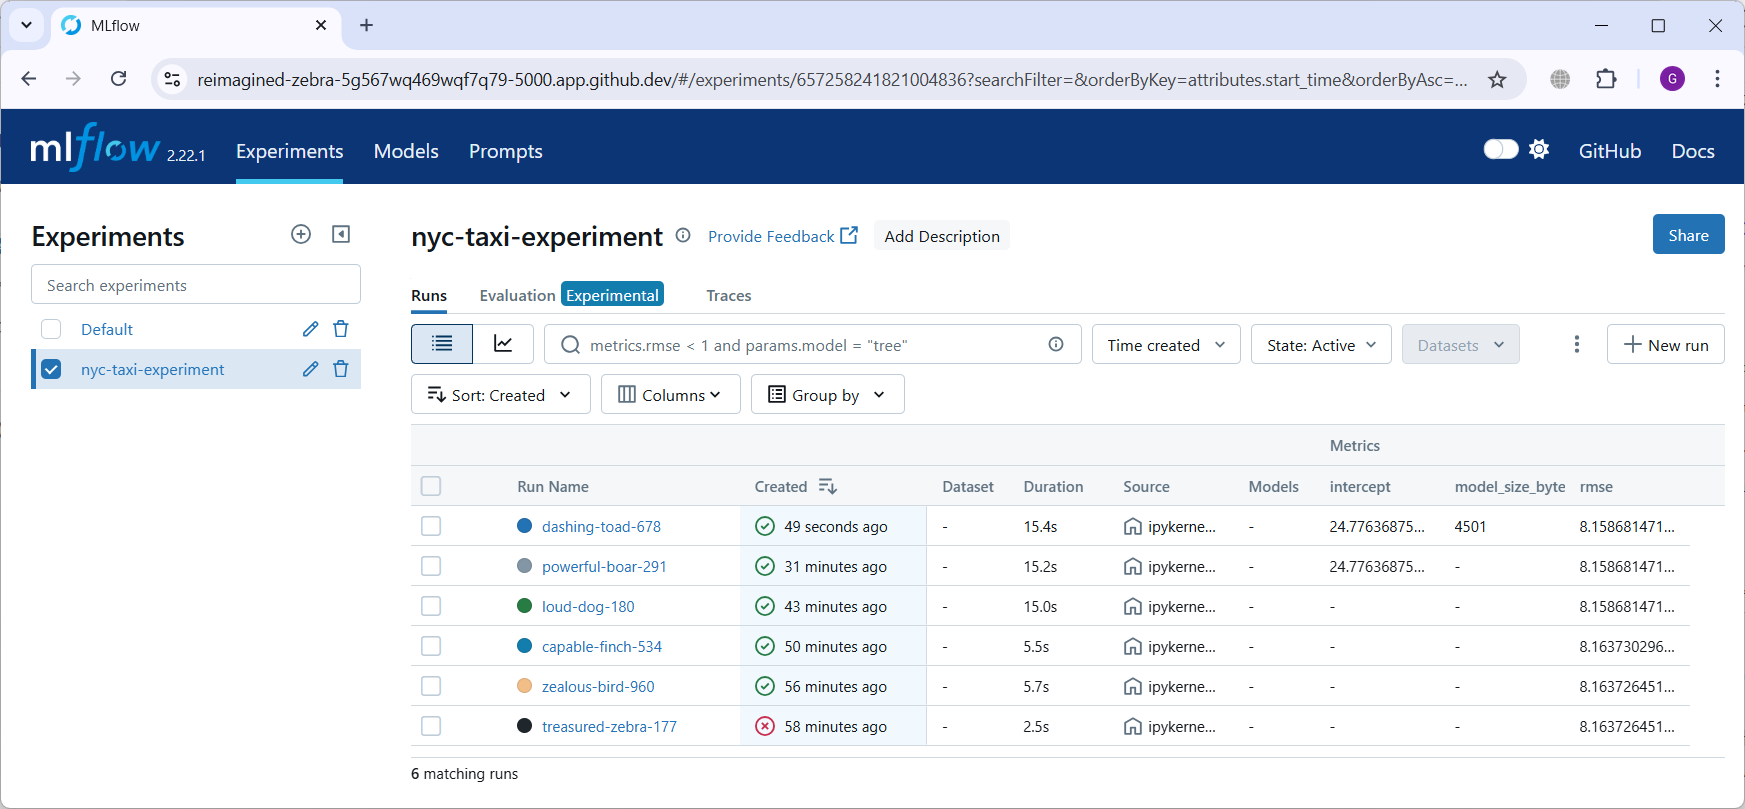